In [43]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## The GE dataset

In [44]:
df = pd.read_csv("data/Rune_Data.csv")

In [45]:
df.head()

,timestamp,Fire_rune,Water_rune,Air_rune,Earth_rune,Mind_rune,Body_rune,Death_rune,Nature_rune,Chaos_rune,Law_rune,Cosmic_rune,Blood_rune,Soul_rune
0,1560038400000,5,5,5,5,4,4,213,209,99,202,119,365,147
1,1560124800000,5,5,5,5,4,4,213,209,99,202,122,364,147
2,1560211200000,5,5,5,5,4,4,213,211,99,203,127,360,147
3,1560297600000,5,5,5,5,4,4,211,212,99,203,125,357,147
4,1560384000000,5,5,5,5,4,4,207,213,99,203,119,353,147


In [46]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [47]:
TRAIN_SPLIT = 120

In [48]:
tf.random.set_seed(13)

## Part 1: Univariate time series

In [49]:
uni_data = df['Chaos_rune']
uni_data.index = df['timestamp']
uni_data.head()

timestamp
1560038400000    99
1560124800000    99
1560211200000    99
1560297600000    99
1560384000000    99
Name: Chaos_rune, dtype: int64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000023A36DE9B38>],
      dtype=object)

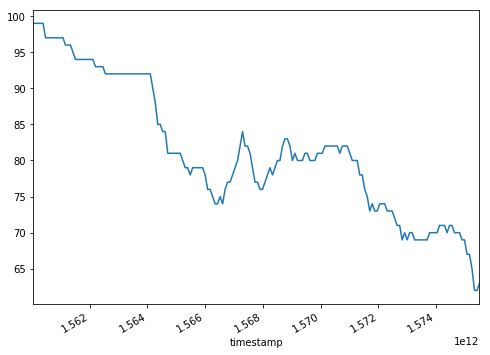

In [50]:
uni_data.plot(subplots=True)

In [51]:
uni_data = uni_data.values

It is important to normalize features before training a neural network. A common way to do so is by subtracting the mean and dividing by the standard deviation of each feature.

Note: The mean and standard deviation should only be computed using the training data.

In [52]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

Let's normalize the data.

In [53]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

Let's now create the data for the univariate model. For part 1, the model will be given the last 20 recorded temperature observations, and needs to learn to predict the temperature at the next time step. 

In [54]:
univariate_past_history = 10
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

This is what the `univariate_data` function returns.

In [56]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target to predict')
print (y_train_uni[0])

Single window of past history
[[1.76042168]
 [1.76042168]
 [1.76042168]
 [1.76042168]
 [1.76042168]
 [1.49685262]
 [1.49685262]
 [1.49685262]
 [1.49685262]
 [1.49685262]]

 Target to predict
1.4968526184903184


Now that the data has been created, let's take a look at a single example. The information given to the network is given in blue, and it must predict the value at the red cross.

In [57]:
def create_time_steps(length):
  time_steps = []
  for i in range(-length, 0, 1):
    time_steps.append(i)
  return time_steps

In [58]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\Christopher Kok\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

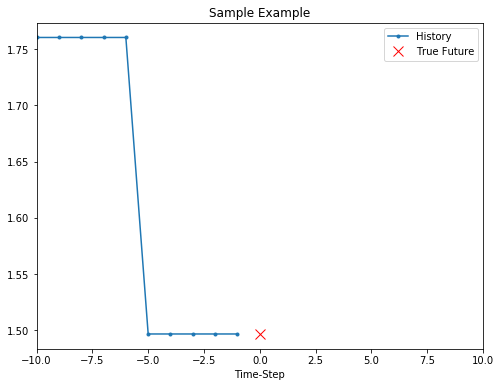

In [59]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

### Baseline
Before proceeding to train a model, let's first set a simple baseline. Given an input point, the baseline method looks at all the history and predicts the next point to be the average of the last 20 observations.

In [60]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from 'C:\\Users\\Christopher Kok\\Anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

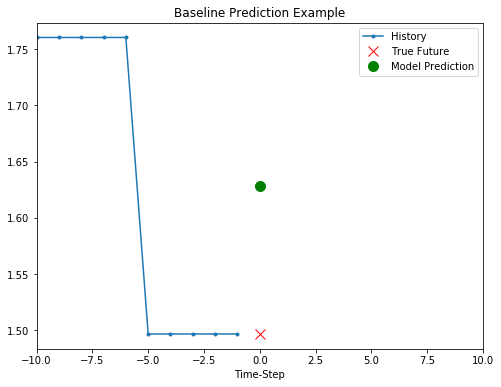

In [61]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

Let's see if you can beat this baseline using a recurrent neural network.

### Recurrent neural network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state summarizing the information they've seen so far. For more details, read the [RNN tutorial](https://www.tensorflow.org/tutorials/sequences/recurrent). In this tutorial, you will use a specialized RNN layer called Long Short Term Memory ([LSTM](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/LSTM))

Let's now use `tf.data` to shuffle, batch, and cache the dataset.

In [62]:
BATCH_SIZE = 20
BUFFER_SIZE = 5

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

The following visualisation should help you understand how the data is represented after batching.

![Time Series](images/time_series.png)

You will see the LSTM requires the input shape of the data it is being given.

In [63]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

Let's make a sample prediction, to check the output of the model. 

In [64]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(20, 1)


Let's train the model now. Due to the large size of the dataset, in the interest of saving time, each epoch will only run for 200 steps, instead of the complete training data as normally done.

In [65]:
EVALUATION_INTERVAL = 500
EPOCHS = 15

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 500 steps, validate for 50 steps
Epoch 1/15
500/500 [==============================] - 6s 11ms/step - loss: 0.2710 - val_loss: 1.0685
Epoch 2/15
500/500 [==============================] - 3s 7ms/step - loss: 0.1567 - val_loss: 0.7484
Epoch 3/15
500/500 [==============================] - 3s 7ms/step - loss: 0.1149 - val_loss: 0.5184
Epoch 4/15
500/500 [==============================] - 3s 6ms/step - loss: 0.0962 - val_loss: 0.3755
Epoch 5/15
500/500 [==============================] - 3s 7ms/step - loss: 0.0821 - val_loss: 0.3416
Epoch 6/15
500/500 [==============================] - 3s 6ms/step - loss: 0.0761 - val_loss: 0.3192
Epoch 7/15
500/500 [==============================] - 3s 6ms/step - loss: 0.0740 - val_loss: 0.2835
Epoch 8/15
500/500 [==============================] - 3s 7ms/step - loss: 0.0729 - val_loss: 0.2636
Epoch 9/15
500/500 [==============================] - 3s 6ms/step - loss: 0.0719 - val_loss: 0.2429
Epoch 10/15
500/500 [==============================] - 3

#### Predict using the simple LSTM model
Now that you have trained your simple LSTM, let's try and make a few predictions.

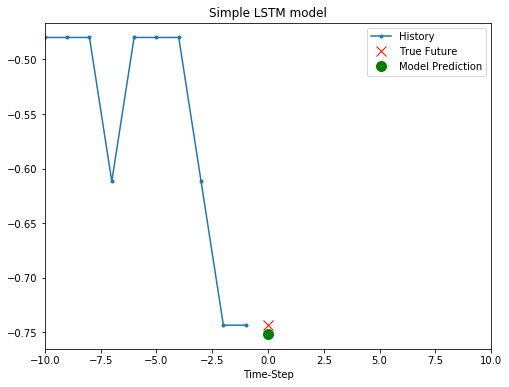

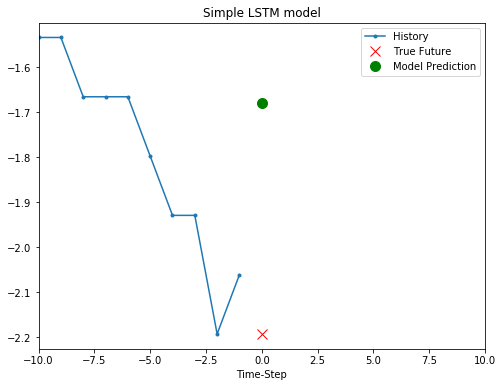

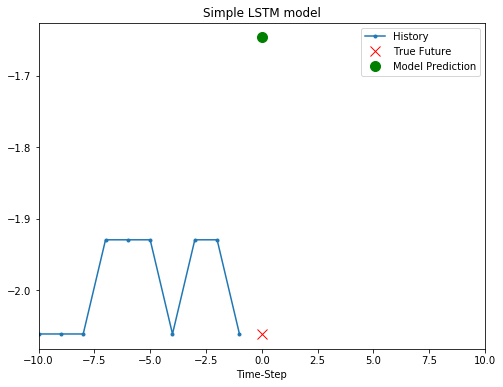

In [66]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

This looks better than the baseline. Now that you have seen the basics, let's move on to part two, where you will work with a multivariate time series.

## Part 2: Multivariate time series

The original dataset contains fourteen features. For simplicity, this section considers only three of the original fourteen. The features used are air temperature, atmospheric pressure, and air density. 

To use more features, add their names to this list.

In [67]:
features_considered = ['Nature_rune', 'Soul_rune', 'Blood_rune', 'Law_rune']

In [68]:
features = df[features_considered]
features.index = df['timestamp']
features.head()

,Nature_rune,Soul_rune,Blood_rune,Law_rune
timestamp,,,,
1560038400000,209,147,365,202
1560124800000,209,147,364,202
1560211200000,211,147,360,203
1560297600000,212,147,357,203
1560384000000,213,147,353,203


Let's have a look at how each of these features vary across time.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000023A46613D68>,
      dtype=object)

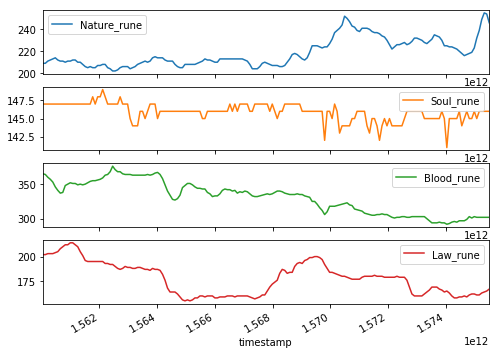

In [69]:
features.plot(subplots=True)

As mentioned, the first step will be to normalize the dataset using the mean and standard deviation of the training data.

In [70]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [71]:
dataset = (dataset-data_mean)/data_std

### Single step model
In a single step setup, the model learns to predict a single point in the future based on some history provided.

The below function performs the same windowing task as below, however, here it samples the past observation based on the step size given.

In [72]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

In this tutorial, the network is shown data from the last five (5) days, i.e. 720 observations that are sampled every hour. The sampling is done every one hour since a drastic change is not expected within 60 minutes. Thus, 120 observation represent history of the last five days.  For the single step prediction model, the label for a datapoint is the temperature 12 hours into the future. In order to create a label for this, the temperature after 72(12*6) observations is used.

In [74]:
past_history = 10
future_target = 1
STEP = 1

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

Let's look at a single data-point.


In [75]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (10, 4)


In [76]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [77]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

Let's check out a sample prediction.

In [78]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

(20, 1)


In [79]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Train for 500 steps, validate for 50 steps
Epoch 1/15
500/500 [==============================] - 6s 12ms/step - loss: 0.5241 - val_loss: 0.7969
Epoch 2/15
500/500 [==============================] - 4s 8ms/step - loss: 0.3525 - val_loss: 0.8322
Epoch 3/15
500/500 [==============================] - 3s 7ms/step - loss: 0.3037 - val_loss: 0.8301
Epoch 4/15
500/500 [==============================] - 4s 7ms/step - loss: 0.2562 - val_loss: 0.8538
Epoch 5/15
500/500 [==============================] - 4s 7ms/step - loss: 0.2219 - val_loss: 0.7924
Epoch 6/15
500/500 [==============================] - 4s 7ms/step - loss: 0.2045 - val_loss: 0.8580
Epoch 7/15
500/500 [==============================] - 3s 7ms/step - loss: 0.1923 - val_loss: 0.8634
Epoch 8/15
500/500 [==============================] - 3s 7ms/step - loss: 0.1807 - val_loss: 0.9157
Epoch 9/15
500/500 [==============================] - 3s 7ms/step - loss: 0.1733 - val_loss: 0.9179
Epoch 10/15
500/500 [==============================] - 3

In [80]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Training loss')
  plt.plot(epochs, val_loss, 'r', label='Validation loss')
  plt.title(title)
  plt.legend()

  plt.show()

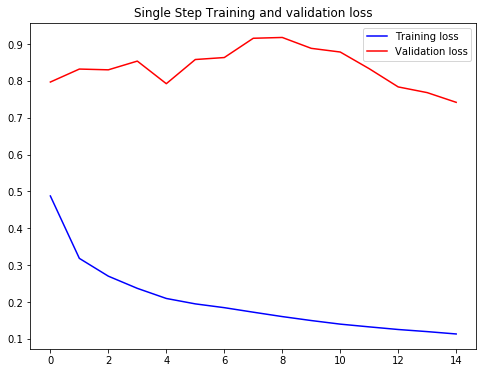

In [81]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

#### Predict a single step future
Now that the model is trained, let's make a few sample predictions. The model is given the history of three features over the past five days sampled every hour (120 data-points), since the goal is to predict the temperature, the plot only displays the past temperature. The prediction is made one day into the future (hence the gap between the history and prediction). 

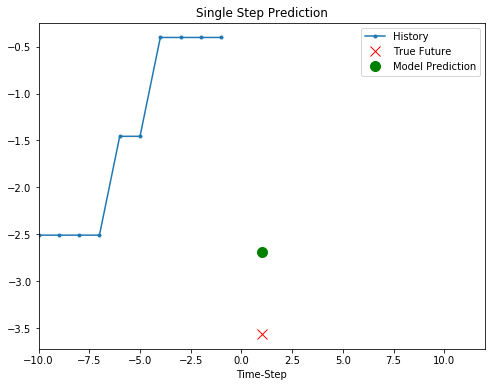

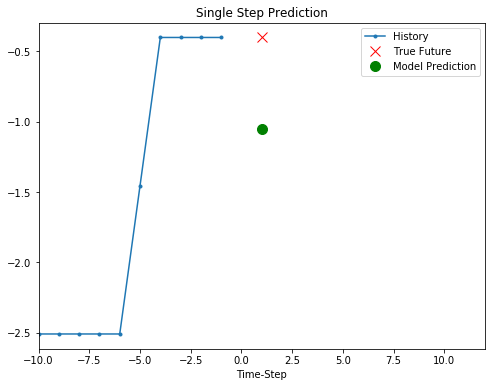

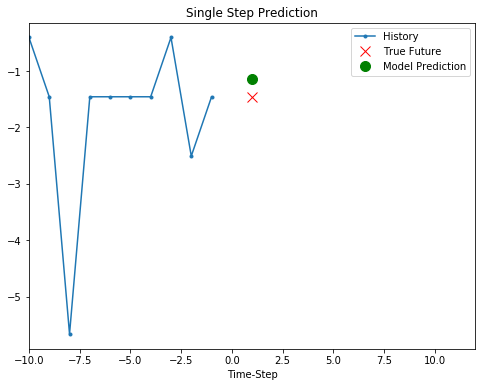

In [83]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 1,
                   'Single Step Prediction')
  plot.show()

### Multi-Step model

In [92]:
future_target = 5
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

Let's check out a sample data-point.

In [93]:
print ('Single window of past history : {}'.format(x_train_multi[0].shape))
print ('\n Target temperature to predict : {}'.format(y_train_multi[0].shape))

Single window of past history : (10, 4)

 Target temperature to predict : (5,)


In [94]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

Plotting a sample data-point.

In [95]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='History')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
  plt.legend(loc='upper left')
  plt.show()

In this plot and subsequent similar plots, the history and the future data are sampled every hour.

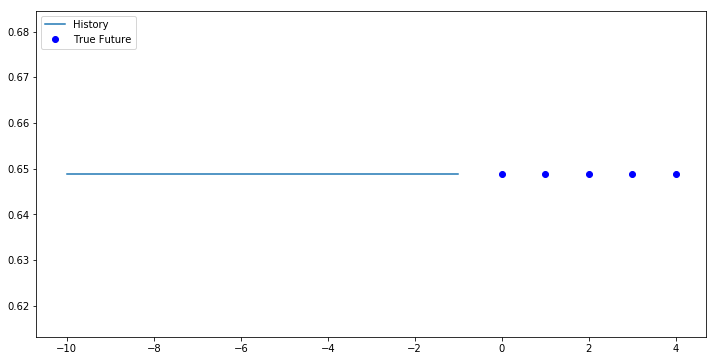

In [96]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

Since the task here is a bit more complicated than the previous task, the model now consists of two LSTM layers. Finally, since 72 predictions are made, the dense layer outputs 72 predictions.

In [97]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
# multi_step_model.add(tf.keras.layers.Dense(72))
multi_step_model.add(tf.keras.layers.Dense(future_target))


multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

Let's see how the model predicts before it trains.

In [98]:
for x, y in val_data_multi.take(1):
  print (multi_step_model.predict(x).shape)

(20, 5)


In [99]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 500 steps, validate for 50 steps
Epoch 1/15
500/500 [==============================] - 9s 19ms/step - loss: 0.5513 - val_loss: 2.1516
Epoch 2/15
500/500 [==============================] - 6s 11ms/step - loss: 0.4033 - val_loss: 1.5591
Epoch 3/15
500/500 [==============================] - 6s 11ms/step - loss: 0.3617 - val_loss: 1.4044
Epoch 4/15
500/500 [==============================] - 6s 11ms/step - loss: 0.3364 - val_loss: 1.1552
Epoch 5/15
500/500 [==============================] - 6s 11ms/step - loss: 0.3170 - val_loss: 1.4709
Epoch 6/15
500/500 [==============================] - 6s 11ms/step - loss: 0.3005 - val_loss: 1.5235
Epoch 7/15
500/500 [==============================] - 6s 11ms/step - loss: 0.2875 - val_loss: 1.7902
Epoch 8/15
500/500 [==============================] - 6s 12ms/step - loss: 0.2754 - val_loss: 1.5193
Epoch 9/15
500/500 [==============================] - 6s 11ms/step - loss: 0.2611 - val_loss: 1.6307
Epoch 10/15
500/500 [===========================

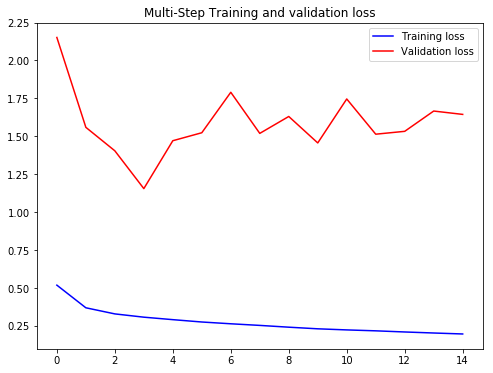

In [100]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

#### Predict a multi-step future
Let's now have a look at how well your network has learnt to predict the future.

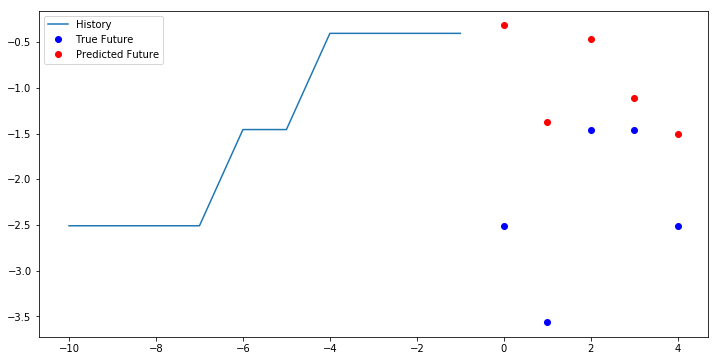

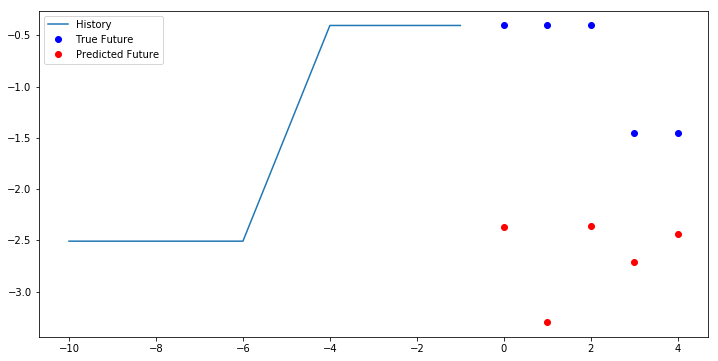

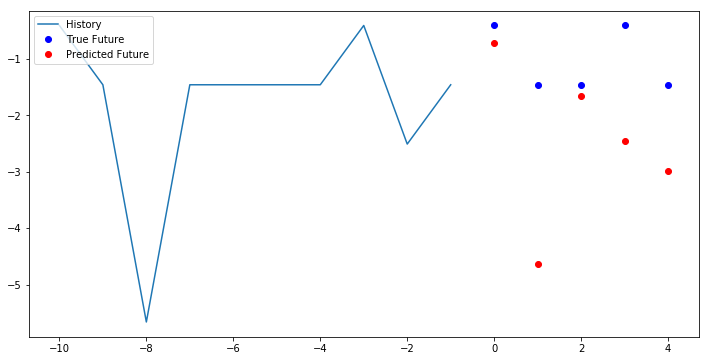

In [101]:
for x, y in val_data_multi.take(3):
  multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])